# Basic Examples with Different Protocols

## Prerequisites

 * A kubernetes cluster with kubectl configured
 * curl
 * grpcurl
 * pygmentize
 
## Examples

  * [Seldon Protocol](#Seldon-Protocol-Model)
  * [Tensorflow Protocol](#Tensorflow-Protocol-Model)
  * [KFServing V2 Protocol](#KFServing-V2-Protocol-Model)
 

## Setup Seldon Core

Use the setup notebook to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html) to setup Seldon Core with an ingress - either Ambassador or Istio.

Then port-forward to that ingress on localhost:8003 in a separate terminal either with:

 * Ambassador: `kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080`
 * Istio: `kubectl port-forward $(kubectl get pods -l istio=ingressgateway -n istio-system -o jsonpath='{.items[0].metadata.name}') -n istio-system 8003:80`

In [1]:
!kubectl create namespace seldon

Error from server (AlreadyExists): namespaces "seldon" already exists


In [2]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "kind-ansible" modified.


In [3]:
import json
import time

In [4]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [5]:
VERSION=!cat ../version.txt
VERSION=VERSION[0]
VERSION

'1.8.0-dev'

## Seldon Protocol Model

We will deploy a REST model that uses the SELDON Protocol namely by specifying the attribute `protocol: seldon`

In [6]:
%%writetemplate resources/model_seldon.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: example-seldon
spec:
  protocol: seldon
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: seldonio/mock_classifier:{VERSION}
          name: classifier
    graph:
      name: classifier
      type: MODEL
    name: model
    replicas: 1

In [7]:
!kubectl apply -f resources/model_seldon.yaml

seldondeployment.machinelearning.seldon.io/example-seldon created


In [8]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=example-seldon -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "example-seldon-model-0-classifier" rollout to finish: 0 of 1 updated replicas are available...
deployment "example-seldon-model-0-classifier" successfully rolled out


In [9]:
for i in range(60):
    state=!kubectl get sdep example-seldon -o jsonpath='{.status.state}'
    state=state[0]
    print(state)
    if state=="Available":
        break
    time.sleep(1)
assert(state=="Available")

Available


In [11]:
X=!curl -s -d '{"data": {"ndarray":[[1.0, 2.0, 5.0]]}}' \
   -X POST http://localhost:8003/seldon/seldon/example-seldon/api/v1.0/predictions \
   -H "Content-Type: application/json"
d=json.loads(X[0])
print(d)
assert(d["data"]["ndarray"][0][0] > 0.4)

{'data': {'names': ['proba'], 'ndarray': [[0.43782349911420193]]}, 'meta': {'requestPath': {'classifier': 'seldonio/mock_classifier:1.6.0-dev'}}}


In [12]:
X=!cd ../executor/proto && grpcurl -d '{"data":{"ndarray":[[1.0,2.0,5.0]]}}' \
         -rpc-header seldon:example-seldon -rpc-header namespace:seldon \
         -plaintext \
         -proto ./prediction.proto  0.0.0.0:8003 seldon.protos.Seldon/Predict
d=json.loads("".join(X))
print(d)
assert(d["data"]["ndarray"][0][0] > 0.4)

{'meta': {'requestPath': {'classifier': 'seldonio/mock_classifier:1.6.0-dev'}}, 'data': {'names': ['proba'], 'ndarray': [[0.43782349911420193]]}}


In [13]:
!kubectl delete -f resources/model_seldon.yaml

seldondeployment.machinelearning.seldon.io "example-seldon" deleted


## Tensorflow Protocol Model
We will deploy a model that uses the TENSORLFOW Protocol namely by specifying the attribute `protocol: tensorflow`

In [18]:
%%writefile resources/model_tfserving.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: example-tfserving
spec:
  protocol: tensorflow
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - args: 
          - --port=8500
          - --rest_api_port=8501
          - --model_name=halfplustwo
          - --model_base_path=gs://seldon-models/tfserving/half_plus_two
          image: tensorflow/serving
          name: halfplustwo
          ports:
          - containerPort: 8501
            name: http
            protocol: TCP
          - containerPort: 8500
            name: grpc
            protocol: TCP
    graph:
      name: halfplustwo
      type: MODEL
      endpoint:
        httpPort: 8501
        grpcPort: 8500
    name: model
    replicas: 1

Overwriting resources/model_tfserving.yaml


In [19]:
!kubectl apply -f resources/model_tfserving.yaml

seldondeployment.machinelearning.seldon.io/example-tfserving created


In [20]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=example-tfserving \
                                 -o jsonpath='{.items[0].metadata.name}')

deployment "example-tfserving-model-0-halfplustwo" successfully rolled out


In [21]:
for i in range(60):
    state=!kubectl get sdep example-tfserving -o jsonpath='{.status.state}'
    state=state[0]
    print(state)
    if state=="Available":
        break
    time.sleep(1)
assert(state=="Available")

Available


In [22]:
X=!curl -s -d '{"instances": [1.0, 2.0, 5.0]}' \
   -X POST http://localhost:8003/seldon/seldon/example-tfserving/v1/models/halfplustwo/:predict \
   -H "Content-Type: application/json"
d=json.loads("".join(X))
print(d)
assert(d["predictions"][0] == 2.5)

{'predictions': [2.5, 3.0, 4.5]}


In [23]:
X=!cd ../executor/proto && grpcurl \
   -d '{"model_spec":{"name":"halfplustwo"},"inputs":{"x":{"dtype": 1, "tensor_shape": {"dim":[{"size": 3}]}, "floatVal" : [1.0, 2.0, 3.0]}}}' \
   -rpc-header seldon:example-tfserving -rpc-header namespace:seldon \
   -plaintext -proto ./prediction_service.proto \
   0.0.0.0:8003 tensorflow.serving.PredictionService/Predict
d=json.loads("".join(X))
print(d)
assert(d["outputs"]["x"]["floatVal"][0] == 2.5)

{'outputs': {'x': {'dtype': 'DT_FLOAT', 'tensorShape': {'dim': [{'size': '3'}]}, 'floatVal': [2.5, 3, 3.5]}}, 'modelSpec': {'name': 'halfplustwo', 'version': '123', 'signatureName': 'serving_default'}}


In [24]:
!kubectl delete -f resources/model_tfserving.yaml

seldondeployment.machinelearning.seldon.io "example-tfserving" deleted


## KFServing V2 Protocol Model

We will deploy a REST model that uses the KFServing V2 Protocol namely by specifying the attribute `protocol: kfserving`

In [25]:
%%writefile resources/model_v2.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: triton
spec:
  protocol: kfserving
  predictors:
  - graph:
      children: []
      implementation: TRITON_SERVER
      modelUri: gs://seldon-models/trtis/simple-model
      name: simple
    name: simple
    replicas: 1

Overwriting resources/model_v2.yaml


In [26]:
!kubectl apply -f resources/model_v2.yaml

seldondeployment.machinelearning.seldon.io/triton created


In [27]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=triton -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "triton-simple-0-simple" rollout to finish: 0 of 1 updated replicas are available...
deployment "triton-simple-0-simple" successfully rolled out


In [28]:
for i in range(60):
    state=!kubectl get sdep triton -o jsonpath='{.status.state}'
    state=state[0]
    print(state)
    if state=="Available":
        break
    time.sleep(1)
assert(state=="Available")

Available


In [29]:
X=!curl -s -d '{"inputs":[{"name":"INPUT0","data":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],"datatype":"INT32","shape":[1,16]},{"name":"INPUT1","data":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],"datatype":"INT32","shape":[1,16]}]}'  \
        -X POST http://0.0.0.0:8003/seldon/seldon/triton/v2/models/simple/infer \
        -H "Content-Type: application/json"
d=json.loads(X[0])
print(d)
assert(d["outputs"][0]["data"][0]==2)

{'model_name': 'simple', 'model_version': '1', 'outputs': [{'name': 'OUTPUT0', 'datatype': 'INT32', 'shape': [1, 16], 'data': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]}, {'name': 'OUTPUT1', 'datatype': 'INT32', 'shape': [1, 16], 'data': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}]}


In [30]:
X=!cd ../executor/api/grpc/kfserving/inference && \
        grpcurl -d '{"model_name":"simple","inputs":[{"name":"INPUT0","contents":{"int_contents":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]},"datatype":"INT32","shape":[1,16]},{"name":"INPUT1","contents":{"int_contents":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]},"datatype":"INT32","shape":[1,16]}]}' \
        -plaintext -proto ./grpc_service.proto \
        -rpc-header seldon:triton -rpc-header namespace:seldon \
        0.0.0.0:8003 inference.GRPCInferenceService/ModelInfer
X="".join(X)
print(X)

{  "modelName": "simple",  "modelVersion": "1",  "outputs": [    {      "name": "OUTPUT0",      "datatype": "INT32",      "shape": [        "1",        "16"      ]    },    {      "name": "OUTPUT1",      "datatype": "INT32",      "shape": [        "1",        "16"      ]    }  ],  "rawOutputContents": [    "AgAAAAQAAAAGAAAACAAAAAoAAAAMAAAADgAAABAAAAASAAAAFAAAABYAAAAYAAAAGgAAABwAAAAeAAAAIAAAAA==",    "AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA=="  ]}


In [31]:
!kubectl delete -f resources/model_v2.yaml

seldondeployment.machinelearning.seldon.io "triton" deleted


## Tensorflow Protocol Multi-Model
We will deploy two models that uses the TENSORLFOW Protocol namely by specifying the attribute `protocol: tensorflow`

 * The demo half_plus_two model
 * A ResNet32 CIFAR10 image classification model

In [6]:
%%writefile resources/model_tfserving.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: example-tfserving
spec:
  protocol: tensorflow
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - args: 
          - --port=8500
          - --rest_api_port=8501
          - --model_config_file=/mnt/models/models.config
          image: tensorflow/serving
          name: multi
          ports:
          - containerPort: 8501
            name: http
            protocol: TCP
          - containerPort: 8500
            name: grpc
            protocol: TCP
    graph:
      name: multi
      type: MODEL
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/multi-model
      endpoint:
        httpPort: 8501
        grpcPort: 8500
    name: model
    replicas: 1

Overwriting resources/model_tfserving.yaml


In [7]:
!kubectl apply -f resources/model_tfserving.yaml

seldondeployment.machinelearning.seldon.io/example-tfserving created


In [8]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=example-tfserving \
                                 -o jsonpath='{.items[0].metadata.name}')

deployment "example-tfserving-model-0-multi" successfully rolled out


In [9]:
for i in range(60):
    state=!kubectl get sdep example-tfserving -o jsonpath='{.status.state}'
    state=state[0]
    print(state)
    if state=="Available":
        break
    time.sleep(1)
assert(state=="Available")

Available


In [23]:
X=!curl -s -d '{"instances": [1.0, 2.0, 5.0]}' \
   -X POST http://localhost:8003/seldon/seldon/example-tfserving/v1/models/half_plus_two/:predict \
   -H "Content-Type: application/json"
d=json.loads("".join(X))
print(d)
assert(d["predictions"][0] == 2.5)

{'predictions': [2.5, 3.0, 4.5]}


In [24]:
X=!cd ../executor/proto && grpcurl \
   -d '{"model_spec":{"name":"half_plus_two"},"inputs":{"x":{"dtype": 1, "tensor_shape": {"dim":[{"size": 3}]}, "floatVal" : [1.0, 2.0, 3.0]}}}' \
   -rpc-header seldon:example-tfserving -rpc-header namespace:seldon \
   -plaintext -proto ./prediction_service.proto \
   0.0.0.0:8003 tensorflow.serving.PredictionService/Predict
d=json.loads("".join(X))
print(d)
assert(d["outputs"]["x"]["floatVal"][0] == 2.5)

{'outputs': {'x': {'dtype': 'DT_FLOAT', 'tensorShape': {'dim': [{'size': '3'}]}, 'floatVal': [2.5, 3, 3.5]}}, 'modelSpec': {'name': 'half_plus_two', 'version': '123', 'signatureName': 'serving_default'}}


In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

train, test = tf.keras.datasets.cifar10.load_data()
X_test, y_test = test
X_test = X_test.astype('float32') / 255
print(X_test.shape, y_test.shape)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

(10000, 32, 32, 3) (10000, 1)


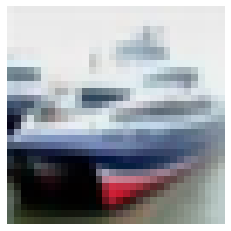

class: ship
prediction: ship


In [26]:
from subprocess import run, Popen, PIPE
import json
import numpy as np
idx=1
test_example=X_test[idx:idx+1].tolist()
payload='{"instances":'+f"{test_example}"+'}'
cmd=f"""curl -s -d '{payload}' \
   -X POST http://localhost:8003/seldon/seldon/example-tfserving/v1/models/cifar10/:predict \
   -H "Content-Type: application/json" \
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res=json.loads(raw)
arr=np.array(res["predictions"][0])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_test[idx][0]])
print("prediction:",class_names[arr.argmax()])

In [24]:
!kubectl delete -f resources/model_tfserving.yaml

seldondeployment.machinelearning.seldon.io "example-tfserving" deleted
